In [1]:
# Import necessary functions
import os
import numpy as np
import json
import yaml
from pprint import pprint  # For better printing of the config dictionary

from experiment_runner import load_config, run_experiment
from IPython.display import Image, Video, display
import time

from utils.plot_utils import animate_trajectory_from_log

Agents package successfully initialized.


Results for this run will be saved in: results/Level1QAgent_vs_IQL_Softmax_2025-07-15_10-48-41


Experiment runs:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 3:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 4:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 5:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 6:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 7:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 8:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 9:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch for experiment 10:   0%|          | 0/10000 [00:00<?, ?it/s]

Plot saved to results/Level1QAgent_vs_IQL_Softmax_2025-07-15_10-48-41/Level1QAgent_vs_IQL_Softmax.png
Saving rewards of both players.
Configuration saved to results/Level1QAgent_vs_IQL_Softmax_2025-07-15_10-48-41/config.yaml


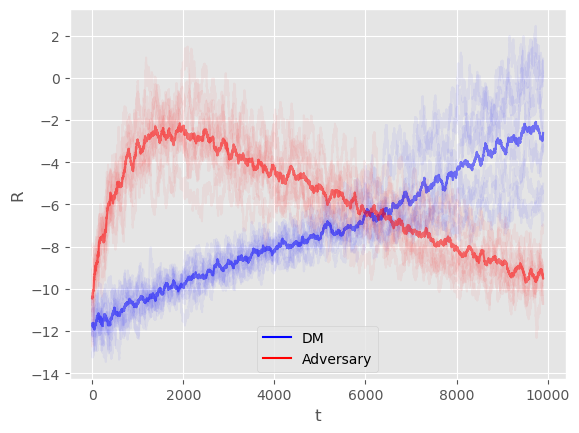

In [4]:
# Load configuration and run the experiment
config_file = 'configs/config.yaml'
config = load_config(config_file)

results_path = run_experiment(config, log_trajectory=True)

In [ ]:
# Specify the Experiment Run to Analyze
# ---------------------------------------------
# TODO: The path can be set to the specific, timestamped experiment folder you want to analyze.

results_run_directory = results_path

In [ ]:
# Verify that the directory exists before proceeding
if not os.path.isdir(results_run_directory):
    raise FileNotFoundError(f"The specified directory does not exist: {results_run_directory}")

print(f"Loading results from: {results_run_directory}")
# --- Load Configuration ---
config_path = os.path.join(results_run_directory, 'config.yaml')
try:
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    print("Configuration file 'config.yaml' loaded successfully.")
    # Use pprint for a cleaner print of the configuration dictionary
    print("\n--- Experiment Configuration ---")
    pprint(config)
    print("--------------------------------")
except FileNotFoundError:
    print(f"Configuration file not found at: {config_path}")
    config = None

# --- Load Reward Data ---
rewards_p1_path = os.path.join(results_run_directory, 'rewards_p1.npy')
rewards_p2_path = os.path.join(results_run_directory, 'rewards_p2.npy')
try:
    # Use np.load to read the saved NumPy array files
    rewards_p1 = np.load(rewards_p1_path)
    rewards_p2 = np.load(rewards_p2_path)
    print(f"\n Reward data loaded successfully. Shape: {rewards_p1.shape}")
except FileNotFoundError:
    print(f"Reward data (.npy files) not found in the directory.")
    rewards_p1, rewards_p2 = None, None
    
# --- Load Trajectory Data ---
# This will only exist if log_trajectory=True was used for the run.
trajectory_path = os.path.join(results_run_directory, 'trajectory_log.npy')
try:
    trajectory_logs_all_experiments = np.load(trajectory_path, allow_pickle=True)
    print(f"\n Trajectory log loaded successfully. Contains {len(trajectory_logs_all_experiments)} run(s).")
except FileNotFoundError:
    print(" Trajectory log ('trajectory_log.npy') not found. Was log_trajectory=True set during the run?")
    trajectory_logs_all_experiments = None

Loading results from: results/Level1QAgent_vs_IQL_Softmax_2025-07-15_10-33-31
Configuration file 'config.yaml' loaded successfully.

--- Experiment Configuration ---
{'agent_settings': {'player_1': {'class': 'LevelKQAgent',
                                 'epsilon_decay': {'end': 0.1,
                                                   'type': 'linear'},
                                 'params': {'epsilon': 1.0,
                                            'gamma': 0.95,
                                            'k': 1,
                                            'learning_rate': 0.5}},
                    'player_2': {'class': 'IndQLearningAgentSoftmax',
                                 'epsilon_decay': {'end': 0.1,
                                                   'type': 'linear'},
                                 'params': {'beta': 1.0,
                                            'epsilon': 1.0,
                                            'gamma': 0.95,
                         


--- Displaying Saved Reward Plot ---


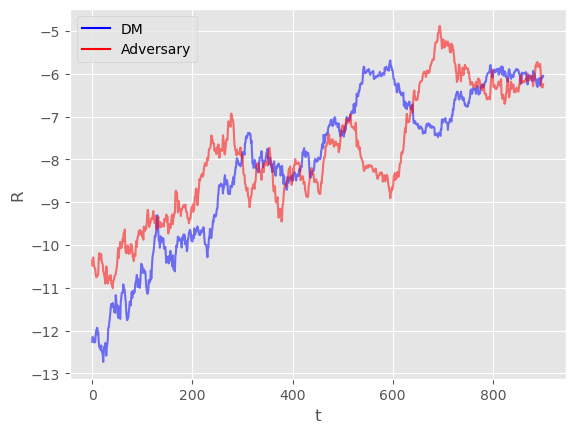


--- Generating Animation from Trajectory Log ---
Animation saved as 'trajectory.mp4'


In [6]:
# Visualize the Loaded Data
# ---------------------------------
# This cell re-creates the plots and animations using the loaded data.

# --- 1. Display the Reward Plot ---
# We can either regenerate the plot from the loaded data or simply display the image that was saved.
# Displaying the image is faster and guarantees we see the original result.
if config is not None:
    print("\n--- Displaying Saved Reward Plot ---")
    experiment_name = config['experiment_settings']['name']
    plot_image_path = os.path.join(results_run_directory, f"{experiment_name}.png")
    
    if os.path.exists(plot_image_path):
        display(Image(filename=plot_image_path))
    else:
        print(" Plot image not found.")
else:
    print("\nSkipping plot display as config was not loaded.")

# --- 2. Animate a Specific Episode from the Trajectory Log ---
if trajectory_logs_all_experiments is not None and config is not None:
    print("\n--- Generating Animation from Trajectory Log ---")
    
    # --- Select which trajectory to animate ---
    # The log is structured as: [experiment_run][episode][step]
    run_to_animate = -1      # The last experiment run
    episode_to_animate = -1  # The last episode of that run
    
    try:
        log_for_one_episode = trajectory_logs_all_experiments[run_to_animate][episode_to_animate]
        
        grid_size = config['environment_settings']['params']['grid_size']
        
        # Generate the animation from this specific episode's log
        animate_trajectory_from_log(log_for_one_episode, grid_size=grid_size, fps=2)
        print("Animation saved as 'trajectory.mp4'")
        
        # Display the generated video in the notebook
        display(Video(url="trajectory.mp4?cache=" + str(time.time()), embed=False))
        
    except (IndexError, TypeError):
        print(" Could not extract the specified trajectory log. Check if the run/episode index is valid.")

else:
    print("\nSkipping animation as trajectory data or config was not loaded.")